In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [2]:
from __future__ import division
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import comptools as comp

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = defaultdict()
for i, composition in enumerate(['light', 'heavy', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df, cut_dict = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

# feature_list, feature_labels = comp.get_training_features()
feature_list = np.array(['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith',
                         'log_NChannels_1_30', 'log_s125', 'StationDensity',
                         'charge_nchannels_ratio', 'charge_nhits_ratio',
                         'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 
                         'stationdensity_nchannels_ratio', 'stationdensity_nhits_ratio',
                         'lap_likelihood', 'log_NHits_1_30', 'log_s50', 'log_s80', 
                         'log_s180', 'log_s250', 'log_s500'])
label_dict = {'reco_log_energy': '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$',
              'lap_log_energy': '$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$',
              'log_s50': '$\log_{10}(S_{\mathrm{50}})$',
              'log_s80': '$\log_{10}(S_{\mathrm{80}})$',
              'log_s125': '$\log_{10}(S_{\mathrm{125}})$',
              'log_s180': '$\log_{10}(S_{\mathrm{180}})$',
              'log_s250': '$\log_{10}(S_{\mathrm{250}})$',
              'log_s500': '$\log_{10}(S_{\mathrm{500}})$',
              'lap_likelihood': '$r\log_{10}(l)$',
              'InIce_charge_1_30': 'InIce charge (top 50\%)',
              'InIce_log_charge_1_30': '$\log_{10}$(InIce charge (top 50\%))',
              'lap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHlap_cos_zenith': '$\cos(\\theta_{\mathrm{Lap}})$',
              'LLHLF_cos_zenith': '$\cos(\\theta_{\mathrm{LLH+COG}})$',
              'lap_chi2': '$\chi^2_{\mathrm{Lap}}/\mathrm{n.d.f}$',
              'NChannels_1_30': 'NChannels (top 50\%)',
              'log_NChannels_1_30' : '$\log_{10}$(NChannels (top 50\%))',
              'StationDensity': 'StationDensity',
              'charge_nchannels_ratio': 'Charge/NChannels',
              'stationdensity_charge_ratio': 'StationDensity/Charge', 
              'NHits_1_30': 'NHits',
              'log_NHits_1_30': '$\log_{10}$(NHits (top 50\%))',
              'charge_nhits_ratio': 'Charge/NHits',
              'nchannels_nhits_ratio': 'NChannels/NHits', 
              'stationdensity_nchannels_ratio': 'StationDensity/NChannels',
              'stationdensity_nhits_ratio': 'StationDensity/NHits'
              }
feature_labels = np.array([label_dict[feature] for feature in feature_list])

print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, comp_class=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

/home/jbourbeau/cr-composition/composition/load_dataframe.py:88: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_dataframe.py:89: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


training features = ['lap_log_energy' 'InIce_log_charge_1_30' 'lap_cos_zenith'
 'log_NChannels_1_30' 'log_s125' 'StationDensity' 'charge_nchannels_ratio'
 'charge_nhits_ratio' 'stationdensity_charge_ratio' 'nchannels_nhits_ratio'
 'stationdensity_nchannels_ratio' 'stationdensity_nhits_ratio'
 'lap_likelihood' 'log_NHits_1_30' 'log_s50' 'log_s80' 'log_s180'
 'log_s250' 'log_s500']
number training events = 145932
number testing events = 62543


/home/jbourbeau/.local/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/jbourbeau/.local/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


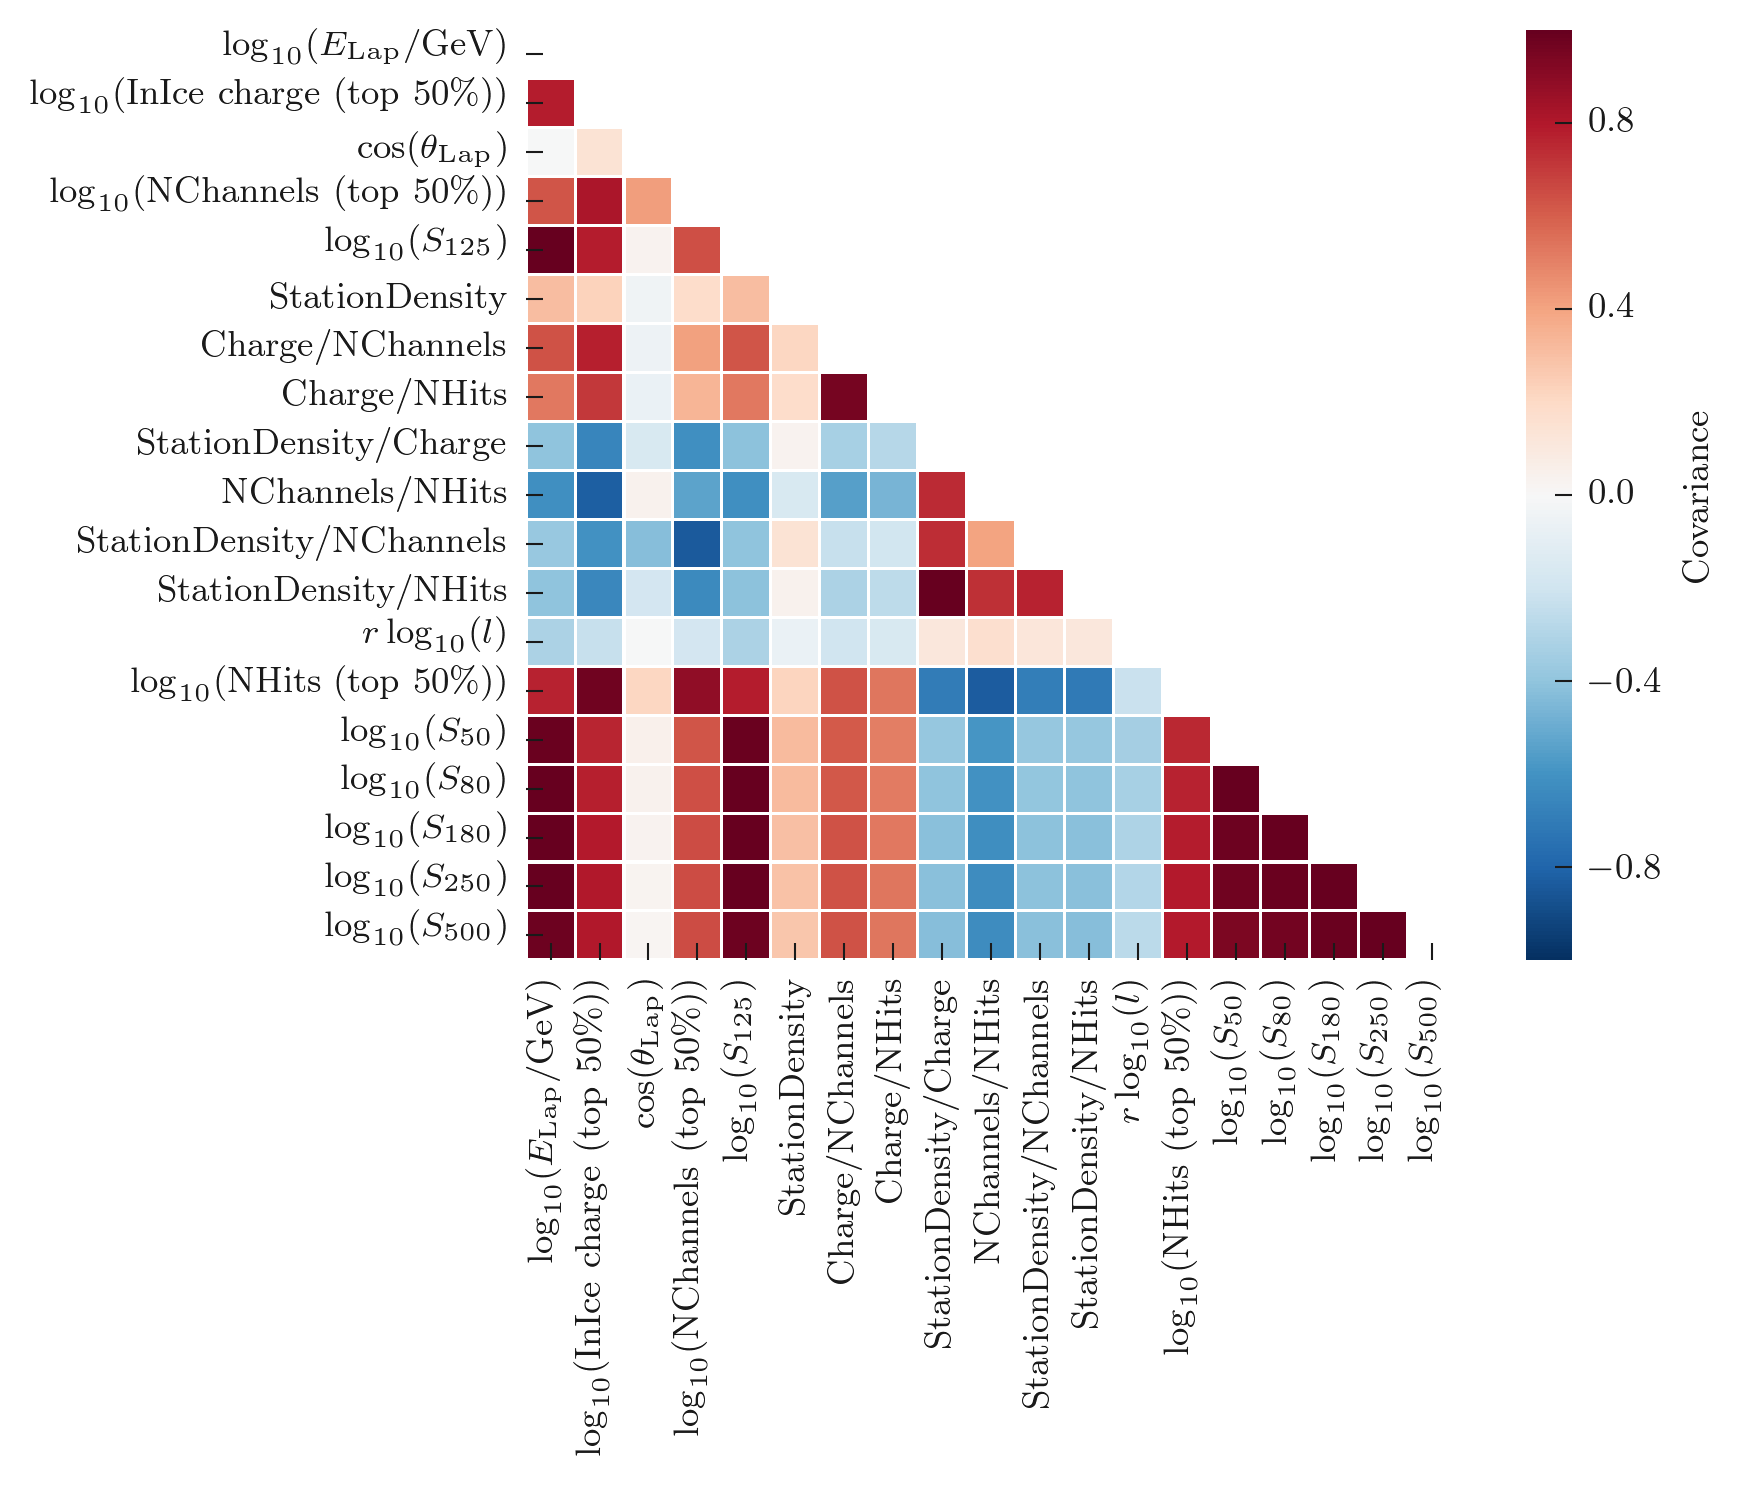

In [4]:
d = pd.DataFrame(df, columns=feature_list)
# Compute the correlation matrix
corr = d.corr()
# corr = d.corr().values
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0,
            square=True, xticklabels=feature_labels, yticklabels=feature_labels,
            linewidths=.5, cbar_kws={'label': 'Covariance'}, annot=False, ax=ax)
plt.show()

In [5]:
d.var()

lap_log_energy                      0.260772
InIce_log_charge_1_30               0.278172
lap_cos_zenith                      0.001151
log_NChannels_1_30                  0.053439
log_s125                            0.302581
StationDensity                      0.016176
charge_nchannels_ratio            181.702621
charge_nhits_ratio                  0.523746
stationdensity_charge_ratio         0.000008
nchannels_nhits_ratio               0.010576
stationdensity_nchannels_ratio      0.000042
stationdensity_nhits_ratio          0.000007
lap_likelihood                      5.191823
log_NHits_1_30                      0.167208
log_s50                             0.317268
log_s80                             0.308305
log_s180                            0.299919
log_s250                            0.299073
log_s500                            0.302115
dtype: float64

In [6]:
feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
num_features = len(feature_list)
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(df, feature_list)

training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125', 'lap_likelihood']


In [6]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']
clf_name = clf.__class__.__name__

In [7]:
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))

Test accuracy: 73.7285%
Train accuracy: 73.9248%


1) 0.381360127017
2) 0.265909889116
3) 0.14942532069
4) 0.115531686641
5) 0.0877729765361


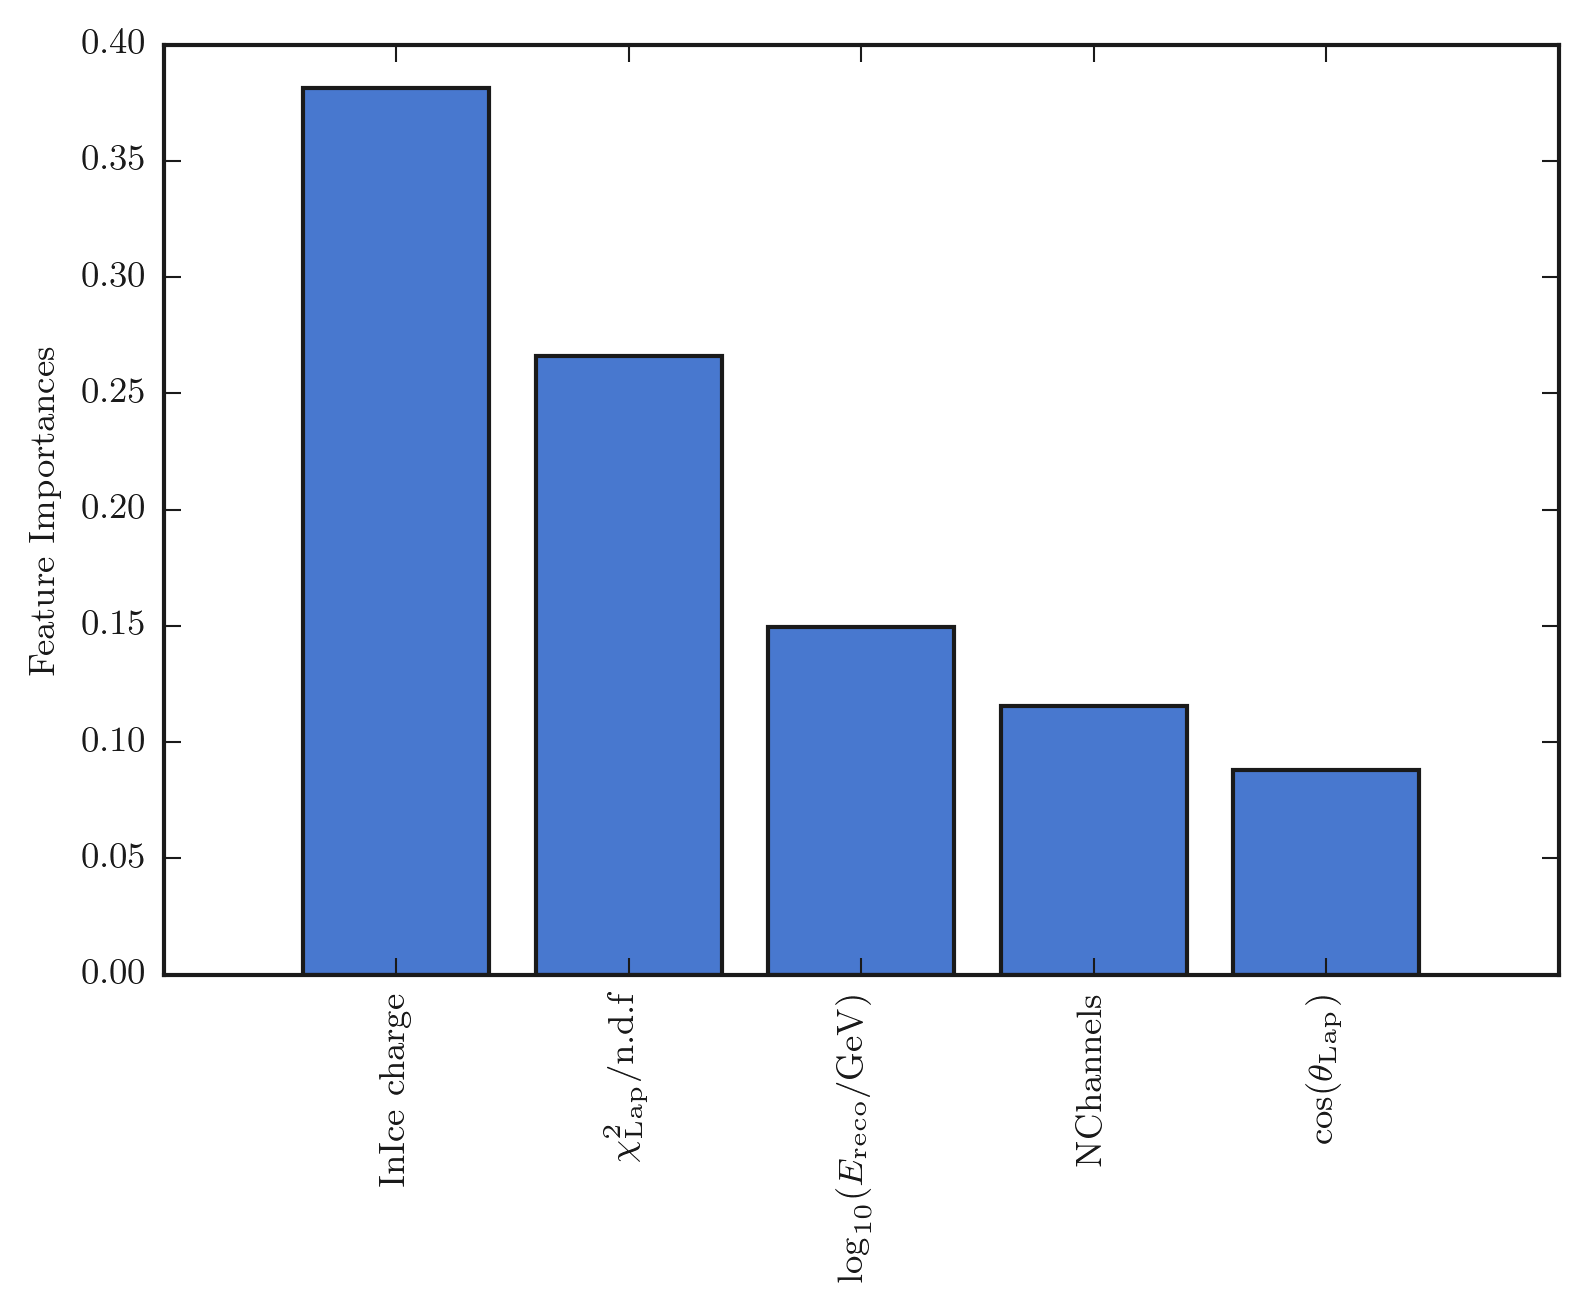

In [8]:
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
plt.show()

In [15]:
corr = d.corr()

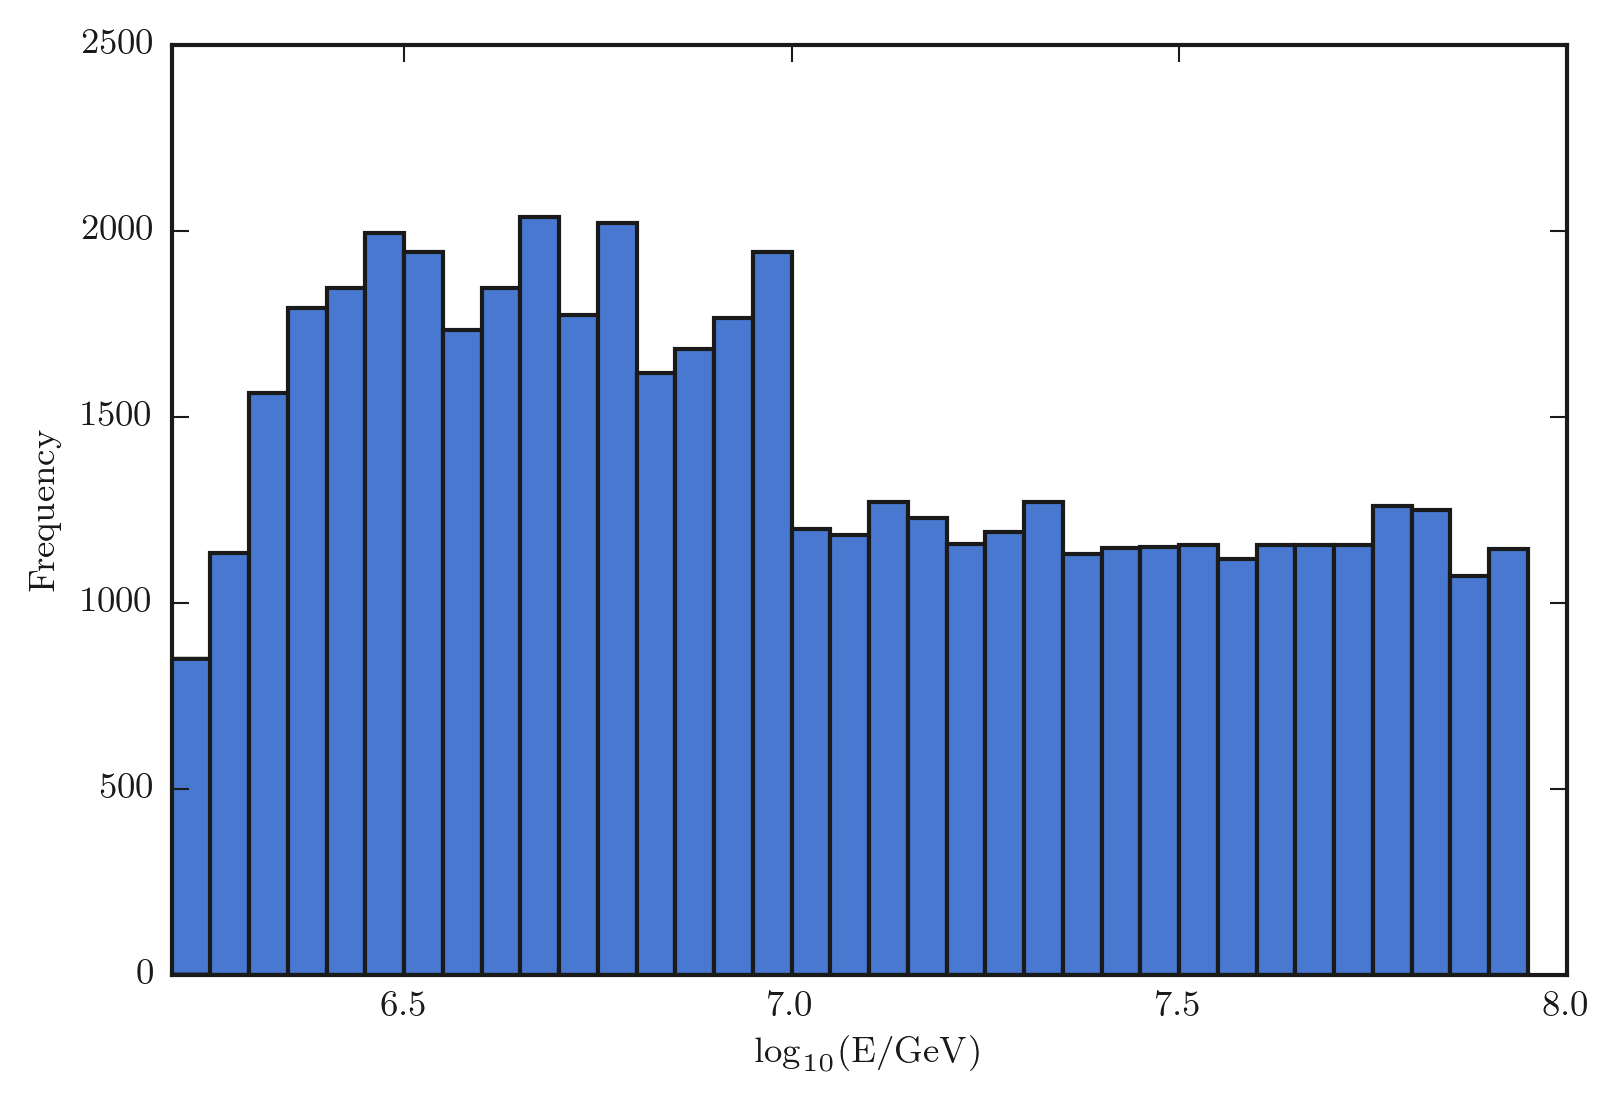

In [16]:
df.MC_log_energy.plot(kind='hist', xlim=[6.2, 8], bins=np.arange(6.2, 8, 0.05))
plt.xlabel('$\\log_{10}({\mathrm{E/GeV})$')

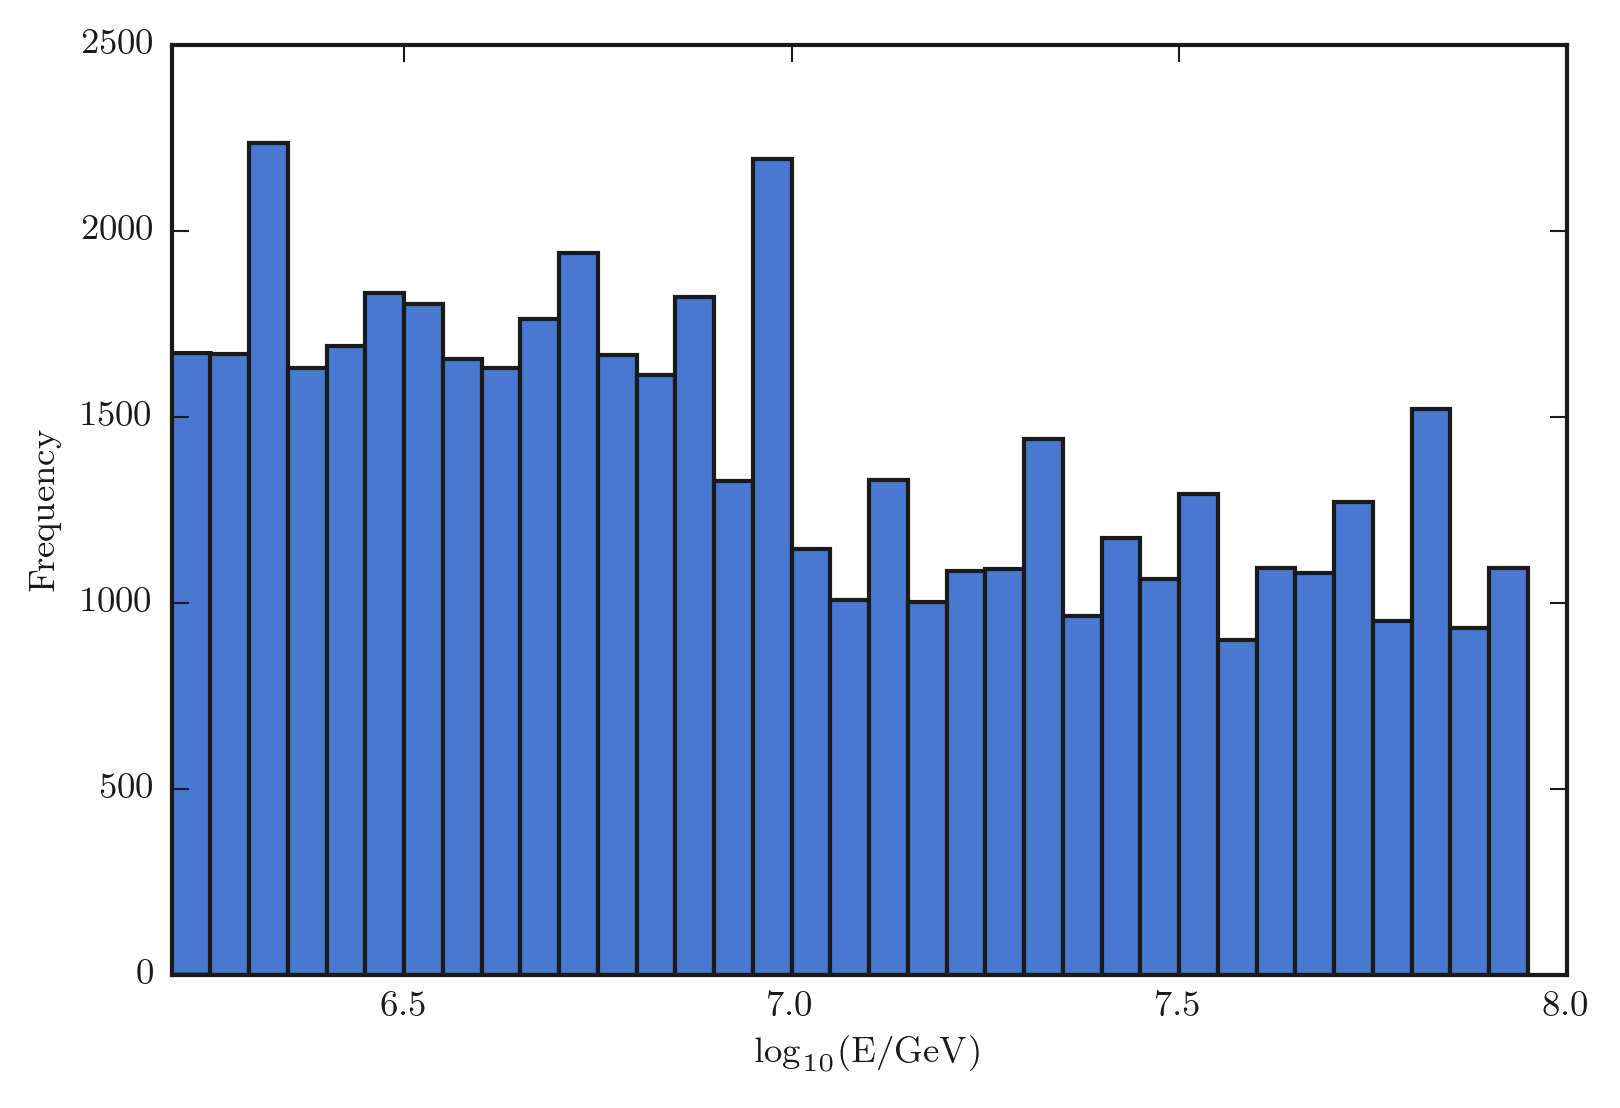

In [17]:
df.reco_log_energy.plot(kind='hist', xlim=[6.2, 8], bins=np.arange(6.2, 8, 0.05))
plt.xlabel('$\\log_{10}({\mathrm{E/GeV})$')

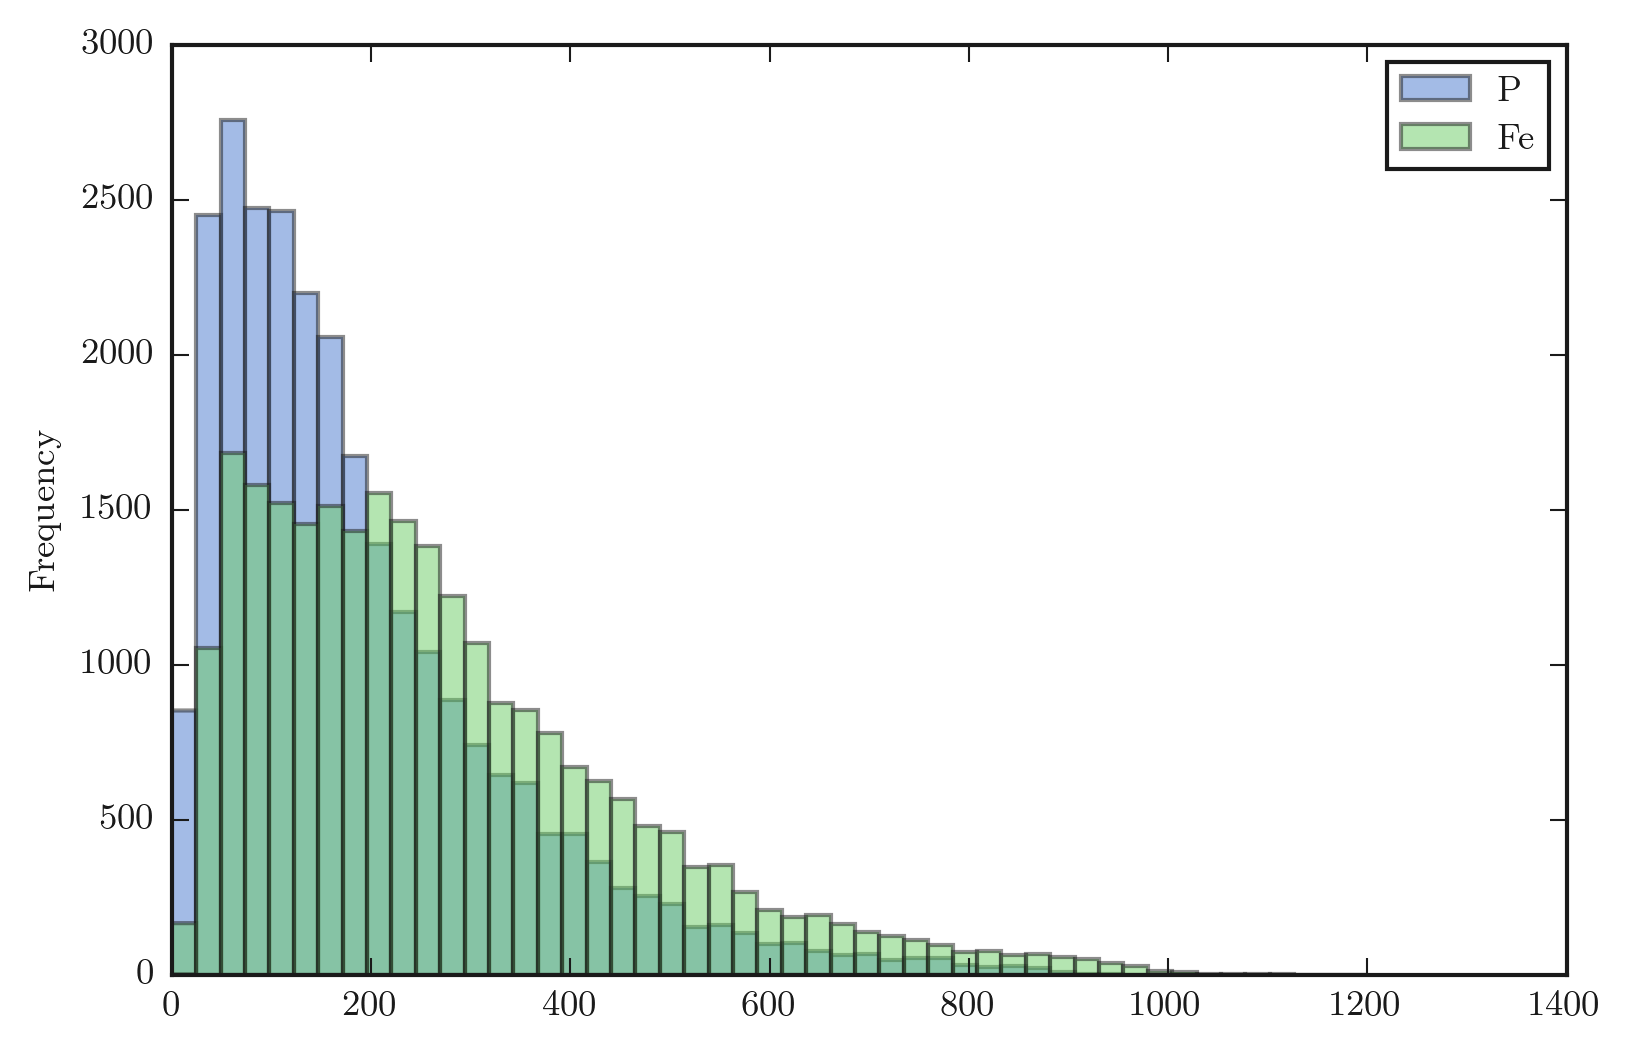

In [18]:
fig, ax = plt.subplots()
df.NChannels[df.MC_comp == 'P'].plot(kind='hist', bins=np.linspace(0, 1200, 50), alpha=0.5, label='P')
df.NChannels[df.MC_comp == 'Fe'].plot(kind='hist', bins=np.linspace(0, 1200, 50), alpha=0.5, label='Fe')
plt.legend()

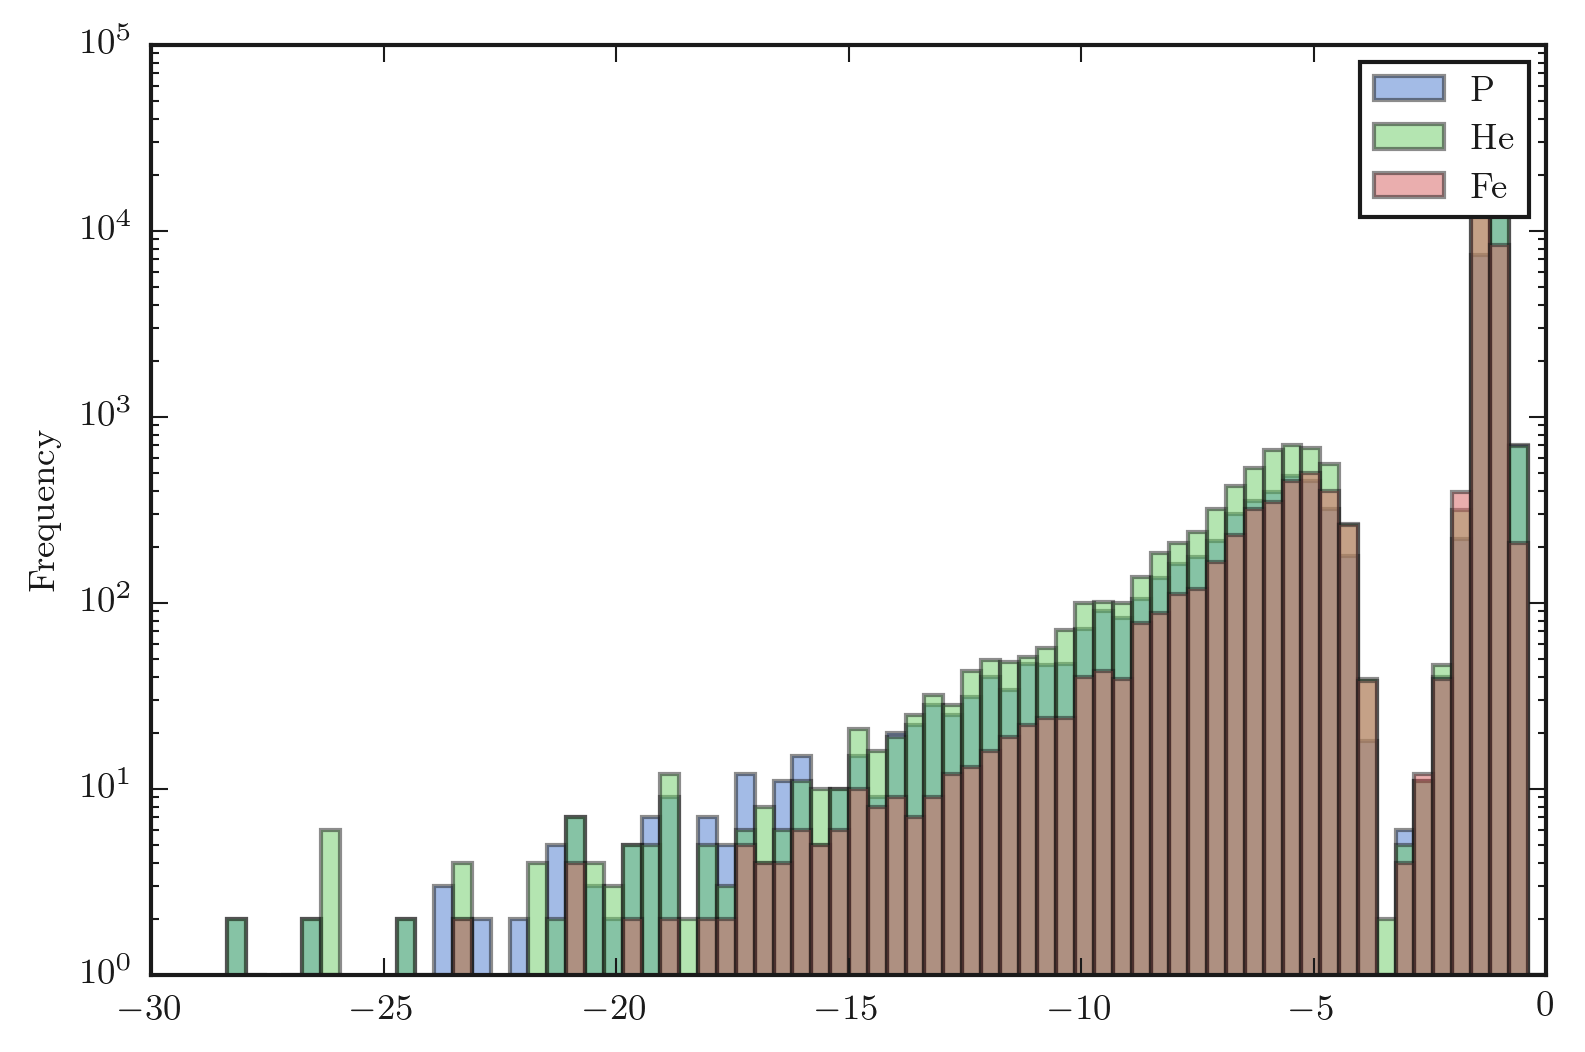

In [13]:
fig, ax = plt.subplots()
df.lap_likelihood[df.MC_comp == 'P'].plot(kind='hist', bins=np.linspace(-30, 0, 75), alpha=0.5, label='P', log=True)
df.lap_likelihood[df.MC_comp == 'He'].plot(kind='hist', bins=np.linspace(-30, 0, 75), alpha=0.5, label='He')
df.lap_likelihood[df.MC_comp == 'Fe'].plot(kind='hist', bins=np.linspace(-30, 0, 75), alpha=0.5, label='Fe')
plt.legend()

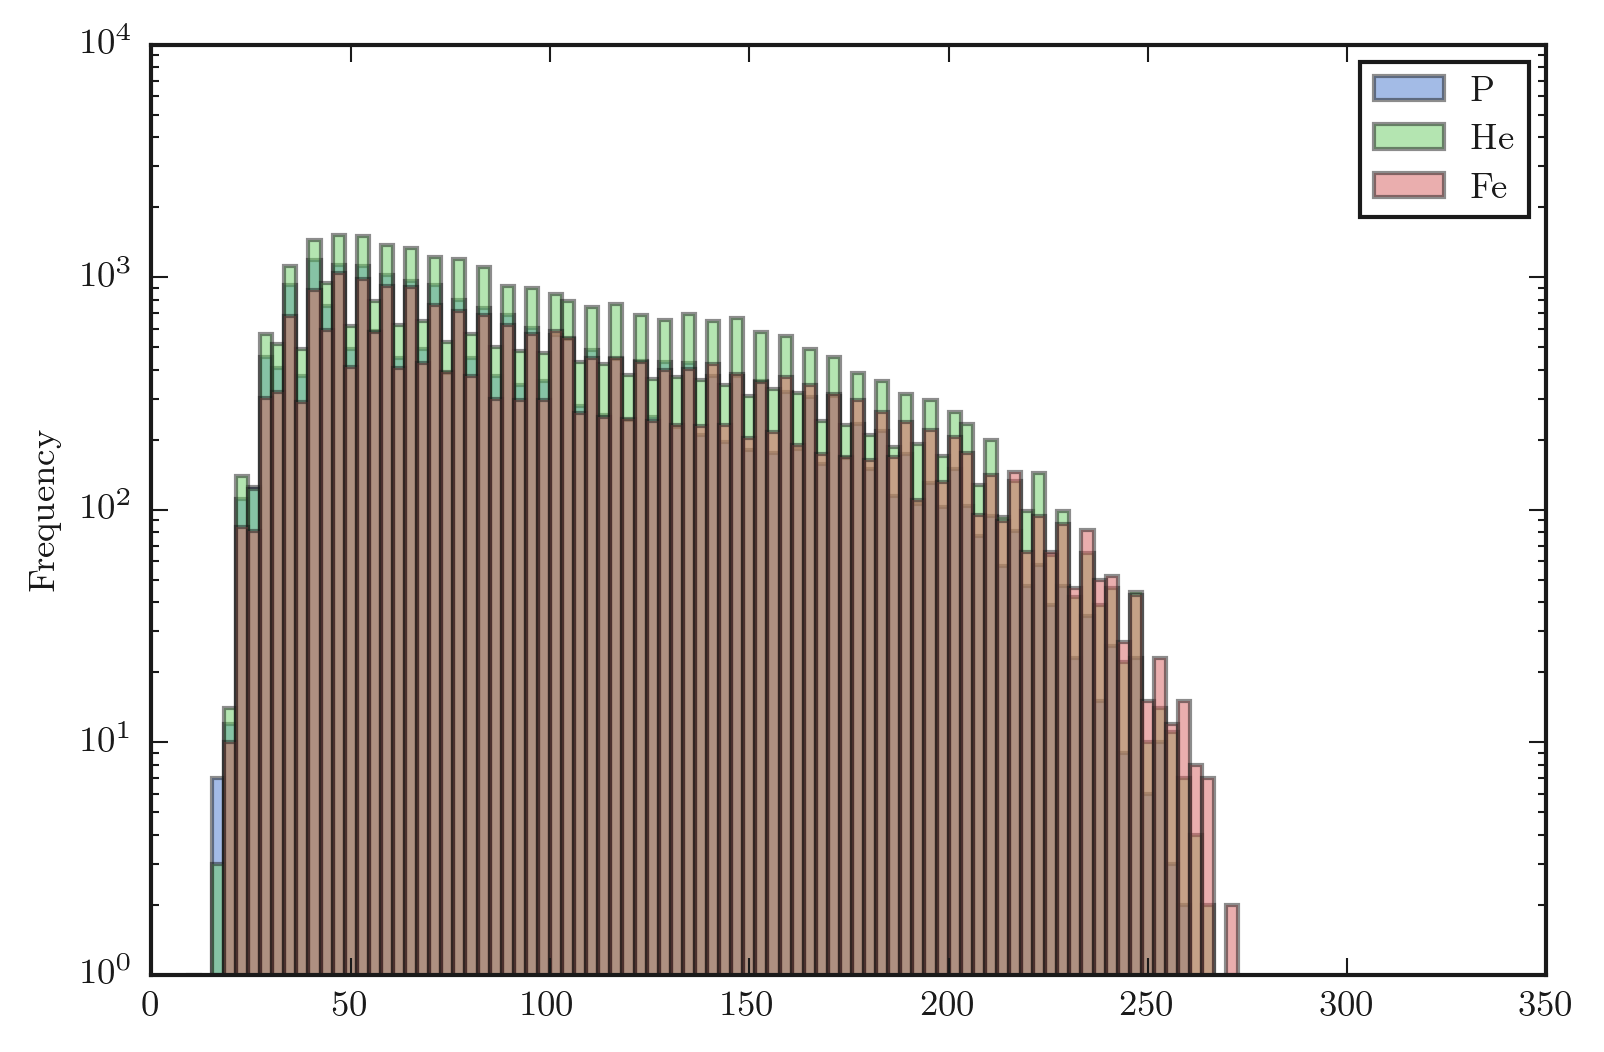

In [10]:
fig, ax = plt.subplots()
df.lap_ndf[df.MC_comp == 'P'].plot(kind='hist', bins=np.linspace(0, 300, 100), alpha=0.5, label='P', log=True)
df.lap_ndf[df.MC_comp == 'He'].plot(kind='hist', bins=np.linspace(0, 300, 100), alpha=0.5, label='He')
df.lap_ndf[df.MC_comp == 'Fe'].plot(kind='hist', bins=np.linspace(0, 300, 100), alpha=0.5, label='Fe')
plt.legend()